In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

from environments.onestep import ARESEAOneStep
from oneshot0script import Simulation

initializing ocelot...


In [2]:
env = ARESEAOneStep()

In [21]:
env.reset()
before = env.segment.AREABSCR1.reading

In [22]:
def black_box_function(q1, q2, q3, cv, ch):
    action = np.array([q1, q2, q3, cv, ch])
    _, reward, _, _ = env.step(action)
    return reward

In [23]:
parameter_bounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [24]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=parameter_bounds
)
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  3.978    |  0.3883   | -0.04292  | -0.6122   |  0.2807   | -0.918    |
|  2        |  2.893    | -0.6101   |  0.7929   | -0.65     | -0.7526   | -0.6211   |
|  3        |  4.15     | -0.9039   |  0.3514   |  0.5542   |  0.5347   | -0.9715   |
|  4        |  4.205    |  0.1318   | -0.3553   | -0.6555   |  0.8563   |  0.9749   |
|  5        |  4.734    |  0.4814   |  0.09557  | -0.2346   | -0.2356   |  0.2164   |
|  6        |  4.136    | -0.01429  |  0.09352  | -0.9569   | -0.3325   |  0.949    |
|  7        |  5.282    |  0.3941   | -0.03339  | -0.3666   |  0.0378   |  0.4857   |
|  8        |  5.273    |  0.6825   | -0.1608   | -0.08974  |  0.1504   |  0.6881   |
|  9        |  4.913    |  1.0      |  0.3812   | -0.4978   |  0.4007   |  0.6198   |
|  10       |  4.582    |  1.0      | -0.6911   | -0.6

Desired: [-3.9280774e-05 -1.5888276e-03  4.7727444e-04  1.3756983e-04]


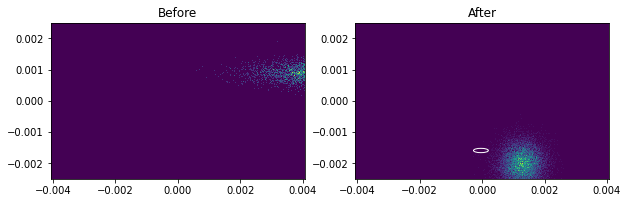

In [25]:
print("Desired:", env.desired)

screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

env.step(np.array([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
]))

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [16]:
simulation = Simulation()
simulation.reset()

array([-1.5970795e+01, -2.0227522e+01, -3.0365849e+00, -2.3424055e-03,
       -5.0537526e-03,  1.9406258e-05, -9.6958305e-04,  1.1257718e-04,
        3.3369160e-04, -2.3870913e-02, -2.0172757e-03,  1.7924888e-02,
        4.4323067e-04], dtype=float32)

In [17]:
before = simulation.segment.AREABSCR1.reading

In [18]:
simulation.track([1, 2, 3, 4, 5])

array([2.2494400e+00, 4.1752610e+00, 4.1667311e-04, 4.1772236e-04],
      dtype=float32)

In [19]:
def black_box_function(q1, q2, q3, cv, ch):
    achieved = simulation.track([q1, q2, q3, cv, ch])
    
    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return np.log((weights * np.abs(offset)).sum())
    
    objective = objective_fn(achieved, simulation.desired)
    
    return objective

In [20]:
parameter_bounds = {
    "q1": (-30, 30),
    "q2": (-30, 30),
    "q3": (-30, 30),
    "cv": (-3e-3, 3e-3),
    "ch": (-6e-3, 6e-3)
}

In [21]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=parameter_bounds
)

In [22]:
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        | -4.797    | -0.006    |  0.002932 | -10.48    |  2.893    |  13.57    |
|  2        | -4.242    |  0.002512 |  0.000824 | -1.549    | -8.549    | -1.609    |
|  3        | -5.788    | -0.001817 | -0.000115 |  4.966    |  1.666    | -16.91    |
|  4        | -4.532    |  0.00214  | -0.001838 | -19.4     |  14.27    |  15.95    |
|  5        | -2.392    | -0.001968 |  0.000128 | -11.9     | -23.22    | -19.54    |
|  6        | -2.368    | -0.004359 | -0.001236 | -11.92    | -22.73    | -20.82    |
|  7        | -1.379    | -0.006    | -0.003    | -30.0     | -30.0     | -30.0     |
|  8        | -1.949    |  0.006    | -0.003    | -30.0     | -9.548    | -30.0     |
|  9        | -4.552    |  0.006    | -0.003    |  30.0     | -30.0     |  30.0     |
|  10       | -2.616    | -0.006    | -0.003    | -30.

In [23]:
optimizer.max

{'target': -1.3719613968434976,
 'params': {'ch': -0.006, 'cv': 0.003, 'q1': -30.0, 'q2': -30.0, 'q3': -30.0}}

Desired: [ 1.9406258e-05 -9.6958305e-04  1.1257718e-04  3.3369160e-04]


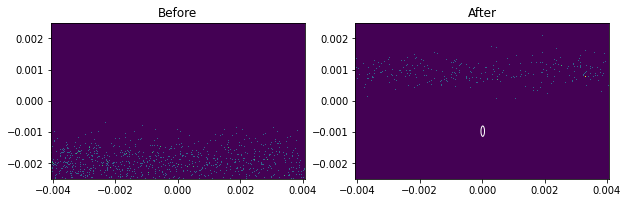

In [27]:
print("Desired:", simulation.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

simulation.track([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
])

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = simulation.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()